## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# Used to underline text in plots
from matplotlib import rc
# to define custom color maps
import matplotlib as mpl
# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_north_south_directory = os.getcwd()
# to print bold in math mode latex
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir("collect_data")
%run get_data.ipynb
os.chdir(cor_mx_north_south_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Function to calculate the probability of correlations between two arrays

In [3]:
def old_sort_AdmUnitIDs_by_AdmUnitID_districts():
    long_districtIDs, short_districtIDs = (list(),list())
    for districtID in districts.keys():
        if len(districtID) == 2: short_districtIDs.append(districtID)
        elif len(districtID) == 3: long_districtIDs.append(districtID)
        else:
            raise Exception("The districtID '" + districtID +
                            "' seems to have more digits than expected.")
    long_districtIDs.sort(), short_districtIDs.sort()
    return  short_districtIDs + long_districtIDs

In [4]:
def sort_AdmUnitIDs_by_AdmUnitID_districts():
    districtIDs = [e for e in districts.keys()]
    districtIDs.sort()
    return districtIDs

In [5]:
# AdmUnitIds = list(covid19.keys())
AdmUnitIds = sort_AdmUnitIDs_by_AdmUnitID_districts()

In [6]:
districtIDs_sorted_by_ID = "\\begin{enumerate}[itemsep=-6mm]\n"
for districtID in AdmUnitIds:
    district_names = non_county_specific_data["district_names"]
    states_with_districts = [e[:-1] for e in district_names.keys()]
    # take state name instead of district, because state has no districts
    if districtID[:-1] in states_with_districts:
        district_name = non_county_specific_data["district_names"][districtID]
    else:
        district_name = non_county_specific_data["states"][districtID[:-1]]
    districtIDs_sorted_by_ID += "\item " + districtID + " " + district_name + "\n"
districtIDs_sorted_by_ID += "\end{enumerate}"

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Anhang")): os.makedirs("results/Anhang")
with open("results/Anhang/districtIDs_sorted_by_ID.tex", "w") as file:
    file.write(districtIDs_sorted_by_ID)
os.chdir(cor_mx_north_south_directory)    # return to original directory

In [7]:
def get_correlation_matrix(get_max_correlation_not_sum = True, max_shift = 50):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId in AdmUnitIds:
        for second_AdmUnitId in AdmUnitIds:
            i1, i2 = (AdmUnitIds.index(AdmUnitId), AdmUnitIds.index(second_AdmUnitId))
            # if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[i1][i2] != 0): continue    # Already set
            correlation = districts[AdmUnitId]["correlation"][second_AdmUnitId].copy()
            offset = max_shift + 1
            while get_max_correlation_not_sum and abs(offset) > max_shift:
                # get the shift with the highest correlation probability
                offset = non_county_specific_data[
                    "correlation_position_array2_to_array1"][np.argmax(correlation)]
                correlation[np.argmax(correlation)] = 0
            if not(get_max_correlation_not_sum):    # sum up all probabilities
                lc = len(correlation)//2
                offset = ((-sum(correlation[lc-max_shift:lc]) +
                          sum(correlation[lc+1:lc+max_shift+1]))/lc)
            correlation_matrix[i1][i2] = offset
            correlation_matrix[i2][i1] = -offset
    return correlation_matrix

In [8]:
correlation_matrizes = list()
matrix_configurations = [(False, 14),  (False, 30), (False, 50),
                         (True, 14), (True, 30), (True, 50)]
for config in matrix_configurations:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

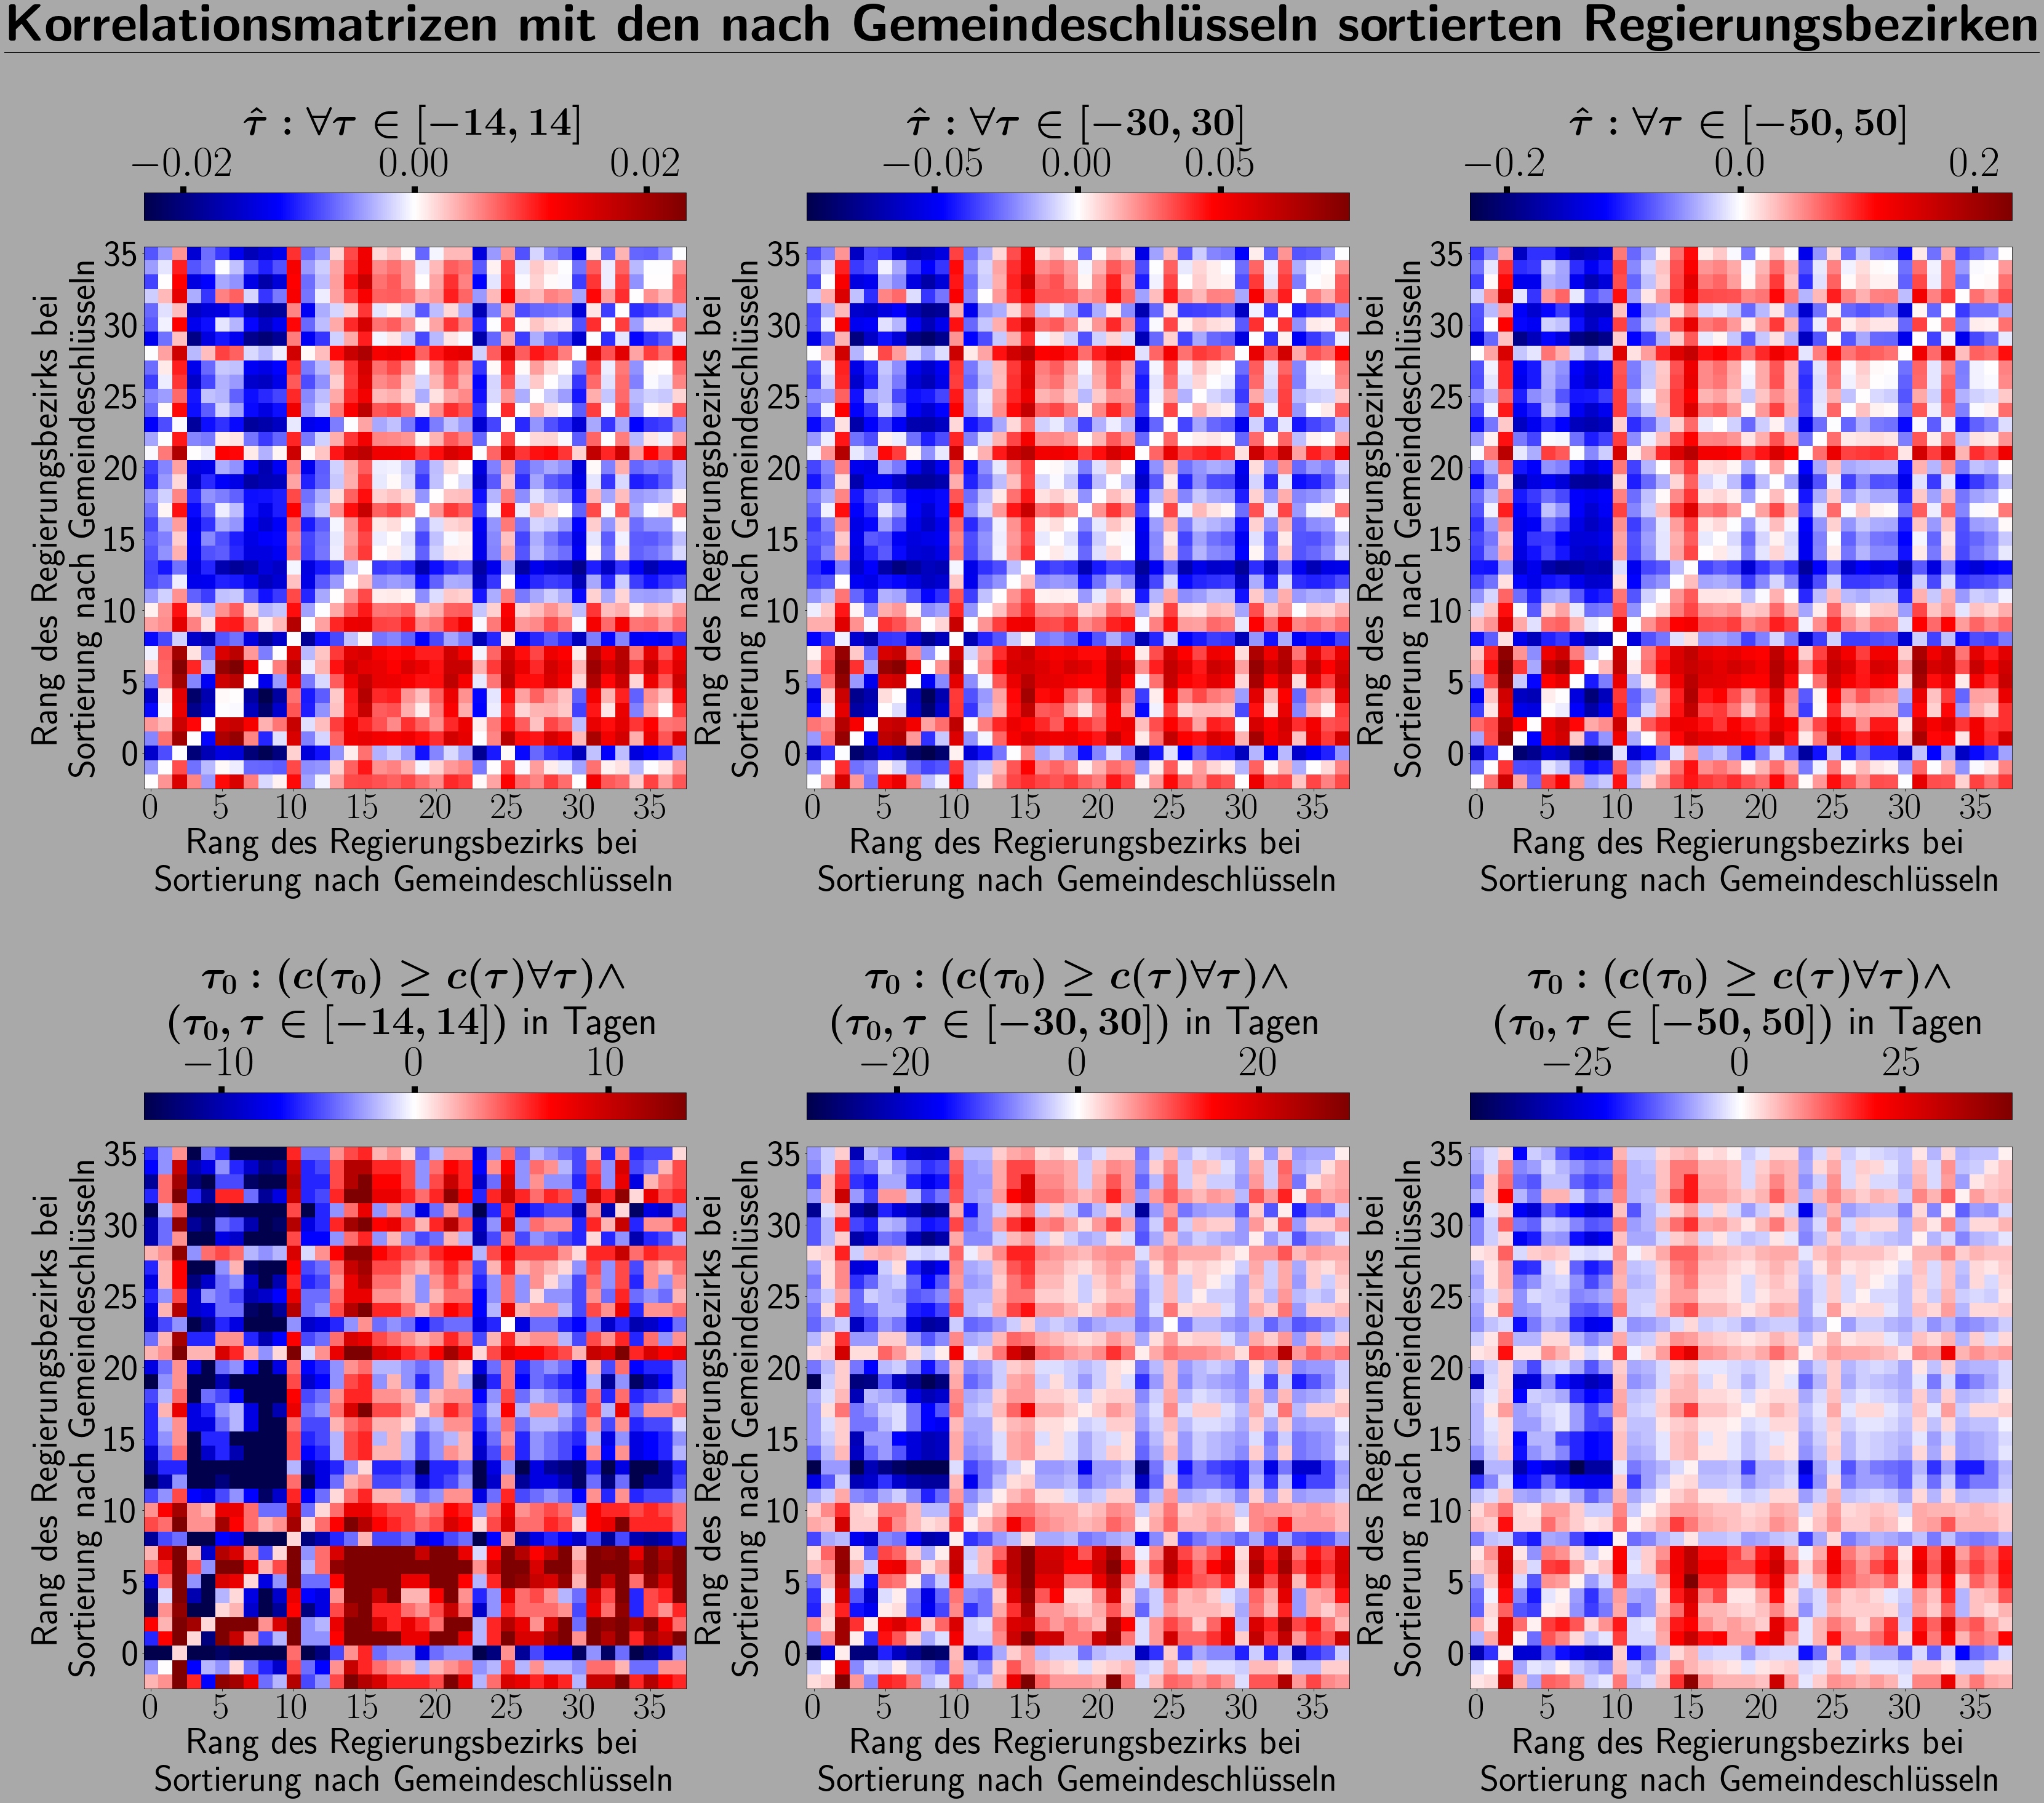

In [30]:
fig, ax = plt.subplots(2,3, figsize = (45, 41), facecolor='darkgrey')

plt.suptitle(r"\textbf{\underline{Korrelationsmatrizen mit den nach " +
             r"Gemeindeschlüsseln sortierten Regierungsbezirken}}",
             fontsize= 85, usetex=True, y=1.01)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//3][i%3]
    im1 = axis.matshow(correlation_matrix[::-1], interpolation='None',
                       cmap= mpl.cm.seismic)
    cax = make_axes_locatable(axis).append_axes('top', size='5%', pad=0.6)
    cbar = fig.colorbar(im1, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=70, size=10, width=10)
    cbar.ax.xaxis.tick_top()
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.set_title(r"$\boldsymbol{\tau_0: (c(\tau_0)\geq c(\tau)\forall\tau)\land}$"+
                       "\n"+
                       r"$\boldsymbol{(\tau_0, \tau\in[-"+shift+r", "+shift+"])}$ in Tagen",
                       fontsize=65, usetex=True, y=1.2)
    else:
        shift = str(matrix_configurations[i][1])
        axis.set_title(r"$\boldsymbol{\hat{\tau}:\forall\tau\in [-"+
                       shift+r", "+shift+r"]}$",
                       fontsize=65, usetex=True, y=1.2) 
    
    axis.xaxis.set_ticks_position("bottom")
    axis.set_ylabel("Rang des Regierungsbezirks bei\nSortierung nach Gemeindeschlüsseln",
                    fontsize=60)
    axis.set_xlabel("Rang des Regierungsbezirks bei\nSortierung nach Gemeindeschlüsseln",
                    fontsize=60)
    axis.set_yticks([e for e in  range(0, len(correlation_matrix)+1,5)])
    axis.set_yticklabels([e for e in range(5*(len(correlation_matrix)//5),-1, -5)])
    plt.setp(axis.get_xticklabels(),fontsize=60)
    plt.setp(axis.get_yticklabels(),fontsize=60)
    #plt.gca().xaxis.tick_bottom()
    
    i+=1
    
os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
plt.tight_layout()
plt.savefig("results/Ergebnisse/matrizes_north_to_south_districts.png",
           bbox_inches='tight')
os.chdir(cor_mx_north_south_directory)    # return to original directory

In [10]:
# hochkantversion der Matrizen
r"""
fig, ax = plt.subplots(3, 2, figsize = (30, 46), facecolor='darkgrey')

ax[0][0].text(2,-16,r'\textbf{\underline{Korrelationsmatrizen der Regierungsbezirke}}',
              fontsize=100, usetex=True)
ax[0][0].text(2,-12,r"\textbf{\underline{Zeilen und Spalten entsprechen }}" +
              r"\textbf{\underline{jeweils der Liste der Regierun}}"+
              r"\textbf{\underline{gsbezirke sortiert nach ihren Gemeindeschlüsseln}}",
              fontsize=39.3, usetex=True)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.text(0,-2,"Die Verschiebung mit dem höchsten\n" +
                        "Korrelationswert zwischen -"+shift+" und "+shift+".",
                        fontsize=45)
    else:
        shift = str(matrix_configurations[i][1])
        axis.text(0,-2,"Tendenz der Verschiebung bei den\n" +
                       "Verschiebungen zwischen -"+shift+" und "+shift+".",
                       fontsize=45)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=1)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
plt.tight_layout(w_pad=-100)
plt.savefig("results/Ergebnisse/matrizes_north_to_south_districts_vertical.png")
os.chdir(cor_mx_north_south_directory)    # return to original directory
"""

'\nfig, ax = plt.subplots(3, 2, figsize = (30, 46), facecolor=\'darkgrey\')\n\nax[0][0].text(2,-16,r\'\\textbf{\\underline{Korrelationsmatrizen der Regierungsbezirke}}\',\n              fontsize=100, usetex=True)\nax[0][0].text(2,-12,r"\\textbf{\\underline{Zeilen und Spalten entsprechen }}" +\n              r"\\textbf{\\underline{jeweils der Liste der Regierun}}"+\n              r"\\textbf{\\underline{gsbezirke sortiert nach ihren Gemeindeschlüsseln}}",\n              fontsize=39.3, usetex=True)\n\ni = 0\nfor correlation_matrix in correlation_matrizes:\n    axis = ax[i//2][i%2]\n    im1 = axis.matshow(correlation_matrix, interpolation=\'None\')\n    if matrix_configurations[i][0]:\n        shift = str(matrix_configurations[i][1])\n        axis.text(0,-2,"Die Verschiebung mit dem höchsten\\n" +\n                        "Korrelationswert zwischen -"+shift+" und "+shift+".",\n                        fontsize=45)\n    else:\n        shift = str(matrix_configurations[i][1])\n        axis.te